<div style = "text-align:center;">
    <h1 style = "color:blue;"> Survival Analysis
</h1>
   </div

## **Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times

## **Introduction**
**Survival analysis is a statistical method used to analyze the time until an event of interest occurs.
The events can include disease occurrence, death, or mechanical failure.
It takes into account censored data, where events have not occurred for some individuals.**

## **Project outline**
**Description of VA lung cancer data,
Kaplan Meier curve estimation,
Fitting Cox Proportional Hazard Regression,
Testing Proportional Hazard assumption**

## [Data Source](https://www.stat.rice.edu/~sneeley/STAT553/Datasets/survivaldata.txt)
**VA lung cancer data** 
  
**Patients with advanced, inoperable lung cancer were treated with 
chemotherapy.** 

**Veteran's Administration Lung Cancer Trial 
Taken from Kalbfleisch and Prentice, pages 223-224** 

# **Data Loading**
##### Here you can see the datа loading from the "dataset_for_my_project" notebook and the first five observations using the head() function.

In [2]:
data = pd.read_csv("Va_lung_cancer_data.csv")
data.head()

,Treatment,Cell Type,Survival(Days),Status,Karnofsky score,Months from Diagnosis,Age,Prior Therapy
0,1,1,72,1,60,7,69,0
1,1,1,411,1,70,5,64,10
2,1,1,228,1,60,3,38,0
3,1,1,126,1,60,9,63,10
4,1,1,118,1,70,11,65,10


## **Check the shape** 
##### Check the shape of data using **.shape** attribute.
##### The data consist of 137 observations and 8 variables (columns).

In [3]:
data.shape

(137, 8)

# **Data Description**
## Variables

1. Treatment:
    * 1 = standard
    * 2 = test
2. Cell type: 
    * 1 = squamous 
    * 2 = small cell 
    * 3 = adeno 
    * 4 = large
3. Survival in days 
4. Status: 
    * 1 = dead
    * 0 = censored 
5. Karnofsky score (measure of general performance, 100=best) **(! Check down what is that )**
6. Months from Diagnosis 
7. Age in years 
8. Prior therapy: 
    * 0 = no 
    * 10 = yes 

## **! Important addition**
### [Karnofsky score](https://en.wikipedia.org/wiki/Performance_status)
##### The Karnofsky Performance Score (KPS) ranking runs from 100 to 0, where 100 is "perfect" health and 0 is death. Practitioners occasionally assign performance scores in between standard intervals of 10. This scoring system is named after Dr. David A. Karnofsky, who described the scale with Dr. Walter H. Abelmann, Dr. Lloyd F. Craver, and Dr. Joseph H. Burchenal in 1948.The primary purpose of its development was to allow physicians to evaluate a patient's ability to survive chemotherapy for cancer.
### **You can see also** [Karnofsky Performance Status scale](https://www.uptodate.com/contents/image?imageKey=PC%2F58785)

# **Base label fixing**

##### The "Tratment" is categorical data. The status consists of 1: standard and 2: test; We can keep it, but I usually prefer the base label for categorical variable as zero.To make the base label 0 - deduct 1 from the variable.

In [4]:
data["Treatment"] = data["Treatment"] - 1
print(data.head())

   Treatment  Cell Type  Survival(Days)  Status  Karnofsky score  \
0          0          1              72       1               60   
1          0          1             411       1               70   
2          0          1             228       1               60   
3          0          1             126       1               60   
4          0          1             118       1               70   

   Months from Diagnosis  Age  Prior Therapy  
0                      7   69              0  
1                      5   64             10  
2                      3   38              0  
3                      9   63             10  
4                     11   65             10  


# **Check data types**
##### With **.dtypes** attribute we can see the data types. Treatment, Cell Type, Syrvival(Days), Karnofsky score, Months from Diagnosis,Age and Prior Therapy are of integer64 type while Status is boolean

In [5]:
data.dtypes 

Treatment                int64
Cell Type                int64
Survival(Days)           int64
Status                   int64
Karnofsky score          int64
Months from Diagnosis    int64
Age                      int64
Prior Therapy            int64
dtype: object

# **Checking for missing values** 
##### in this project I selected data in which there were no variables that contained missing values, but if there were such data, this could be done in several ways (e.g. removing entirely (but this will reduce the sample) or imputing missing values)

In [6]:
data.isnull().sum()

Treatment                0
Cell Type                0
Survival(Days)           0
Status                   0
Karnofsky score          0
Months from Diagnosis    0
Age                      0
Prior Therapy            0
dtype: int64

# **Bar plot**
##### This code generates a bar plot that visually represents the distribution of treatments in a dataset. The x-axis represents the treatments, the y-axis represents the count of each treatment, and the bar heights correspond to the respective counts.

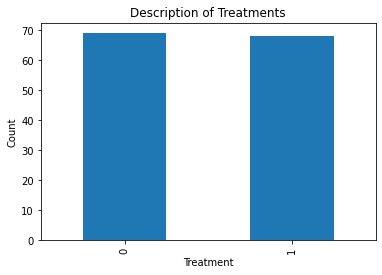

In [7]:
data["Treatment"].value_counts().plot(kind = "bar")
plt.xlabel("Treatment")
plt.ylabel("Count")
plt.title("Description of Treatments")
plt.show()

# **Scatter plot**
##### This code generates a scatter plot that allows us to examine the relationship between the "Survival(Days)" variable and the "Age" variable. The x-axis represents the number of days of survival, while the y-axis represents the age. Each dot on the scatter plot represents a data point, allowing us to visually analyze any patterns or correlations between age and survival in the dataset.

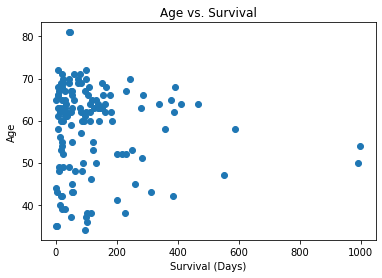

In [8]:
plt.scatter(data["Survival(Days)"], data["Age"])
plt.xlabel("Survival (Days)")
plt.ylabel("Age")
plt.title("Age vs. Survival")
plt.show()

# **Data distribution**
## **Histogram**
### **T - Time variable, E - Event/Status variable**
##### This code generates a histogram that shows the distribution of survival days. The x-axis represents the different time intervals or "Survival(Days)" values, while the y-axis represents the frequency or count of occurrences for each interval. The plot helps us visualize the overall distribution and identify any patterns or significant features in the survival time variable.

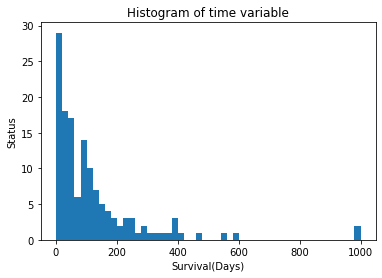

In [9]:
T = data["Survival(Days)"]
E = data["Status"]
plt.hist(T, bins = 50)
plt.xlabel("Survival(Days)")
plt.ylabel("Status")
plt.title("Histogram of time variable")
plt.show() 

# **Kaplan-Meier**
##### The Kaplan-Meier estimator,also known as Kaplan-Meier curve or Kaplan-Meier survival analysis is a statistical method used to estimate the survival or survival probabilities in a group of subjects or patients over time.

## **Kaplan-Meier math formula**
$$\hat{S}(t) = \prod_{t_i < t} \left(\frac{{n_i}-{d_i}}{n_i}\right)$$
**where $di$ are the number of death events at time - $t$ and $ni$
 is the number of subjects at risk of death just prior to time $t$.**

## **Kaplan-Meier Curve Estimation**

**The curve illustrates how survival probabilities change over the time horizon. As time passes, the probability of survival of lung cancer patients decreases.**

##### **kmf = KaplanMeierFitter()**: This line of code creates an instance of the KaplanMeierFitter class, which will be used to perform the Kaplan-Meier estimation.

##### **kmf.fit(durations = T, event_observed = E)**: This line of code fits the Kaplan-Meier estimator to the data. The durations parameter represents the time durations, and the event_observed parameter indicates whether an event (such as death) was observed for each individual.

##### **kmf.plot_survival_function()**: This line of code generates the plot of the estimated survival function using the Kaplan-Meier estimator.

##### **plt.title("KM Plot with 95% CI")**: This line of code sets the title of the plot, which describes the content of the visualization. In this case,the plot represents the Kaplan-Meier plot with a 95% confidence interval.

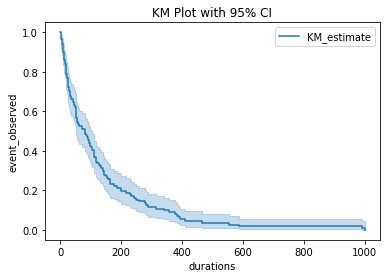

In [10]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()
plt.xlabel("durations")
plt.ylabel("event_observed")
plt.title("KM Plot with 95% CI")
plt.show()

## **Same plot without the 95% confidence interval**

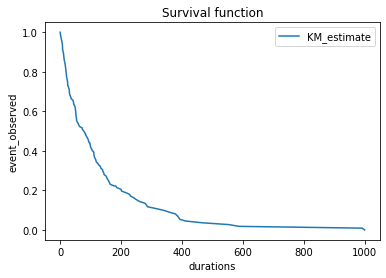

In [11]:
kmf.survival_function_.plot()
plt.xlabel("durations")
plt.ylabel("event_observed")
plt.title('Survival function')
plt.show()

## **Plot of a failure curve. Opposite of survival, i.e., Failure/death probabilities over time.**
##### **kmf.plot_cumulative_density()**: This line plots the cumulative survival curve using the **plot_cumulative_density()** function of the kmf object.

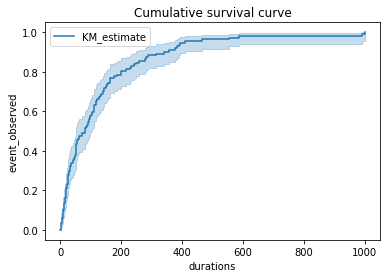

In [12]:
kmf.plot_cumulative_density()
plt.xlabel("durations")
plt.ylabel("event_observed")
plt.title("Cumulative survival curve")
plt.show()

## Median Survival Time and Confidence Intervals

**Estimation of the median survival time and 95% confidence intervals. 
The median survival time is 80 days, which indicates that 50% of the sample live 80 days and 50% dies within this time. The 95% CI lower limit is 52 days, while the upper limit is 100 days.**

##### **median = kmf.median_survival_time_**: This line calculates the median survival time using the median_survival_time_ attribute of the kmf object. The median survival time represents the time at which 50% of the individuals in the survival analysis have experienced the event of interest (such as death or failure).

##### **median_confidence_interval = median_survival_times(kmf.confidence_interval_)**: This line calculates the confidence interval for the median survival time. It uses the median_survival_times() function, which takes the confidence_interval_ attribute of the kmf object as input. This function computes the confidence interval based on the provided confidence interval values.

In [13]:
median = kmf.median_survival_time_
median_confidence_interval = median_survival_times(kmf.confidence_interval_)
print(median)
print(median_confidence_interval)

80.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                    52.0                   100.0


## **Cox Proportional Hazard Model**
**The Cox model, also known as the Cox proportional hazards model, is a statistical method used for analyzing survival data. It helps researchers understand how different factors or variables influence the time until an event of interest occurs, such as death, disease recurrence, or equipment failure.**

**The key assumption of the Cox model is that the hazard function remains proportional over time. The hazard function represents the probability of experiencing the event at any given time. Proportional hazards means that the relative risk of the event happening between two individuals remains constant over time.**

## **Math Formula**
### $$ h(t|X) = h_0(t) \cdot \exp(b_1 X_1 + b_2 X_2 + \ldots + b_p X_p)$$

#### Where:
$h(t|X)$ **represents the hazard function for an individual at time $t$, given the predictor variables** $X_1, X_2, \ldots, X_p$

$h_0(t)$ **is the baseline hazard function, which represents the hazard for an individual with all predictor variables equal to zero.**

$b_1, b_2, \ldots, b_p$ **are the regression coefficients or parameter estimates associated with the predictor variables** $X_1, X_2, \ldots, X_p$

$X_1, X_2, \ldots, X_p$ **are the values of the predictor variables for a specific individual.**

$\exp()$ **is the exponential function.**

### Data preparation
#### Dummy coding
**pd.get_dummies(data["Cell Type"], prefix='C_Type')**: This line of code is calling the **get_dummies()** function from the pandas library. It is used to create dummy variables from a categorical variable. In this case, the categorical variable is **data["Cell Type"]**. Each unique value in **data["Cell Type"]** will be transformed into a separate binary column.

In [14]:
dummies_cell = pd.get_dummies(data["Cell Type"], prefix = 'C_Type')
dummies_cell.head(4)

,C_Type_1,C_Type_2,C_Type_3,C_Type_4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0


### Concatenating to the original data
It selects specific columns from dummies_cell, concatenates them with data, drops the "Cell Type" column, and finally displays the first few rows of the resulting DataFrame.

**dummies_cell = dummies_cell[["C_Type_1", "C_Type_2"]]**: This line of code is selecting specific columns from the **dummies_cell** DataFrame and reassigning the result back to dummies_cell. The columns selected are **"C_Type_1" and "C_Type_2"** This operation keeps only these two columns in the dummies_cell DataFrame and drops any other columns that may have been present.

**data = pd.concat([data, dummies_cell], axis=1)** This line of code uses the **concat()** function from the pandas library to concatenate (combine) two DataFrames along the columns (axis=1). The original DataFrame data and the modified **dummies_cell (containing only "C_Type_1" and "C_Type_2" columns)** are concatenated horizontally. The result is assigned back to data, effectively adding the **"C_Type_1" and "C_Type_2"** columns to the original data.

**data = data.drop("Cell Type", axis=1)**: This line of code uses the **drop()** function from pandas to remove a column from the DataFrame. It removes the column labeled "Cell Type" from the data DataFrame. The axis=1 parameter specifies that we want to drop a column (as opposed to dropping a row).

In [15]:
dummies_cell = dummies_cell[["C_Type_1", "C_Type_2"]]
data = pd.concat([data, dummies_cell], axis = 1)
data = data.drop("Cell Type", axis = 1)
data.head()

,Treatment,Survival(Days),Status,Karnofsky score,Months from Diagnosis,Age,Prior Therapy,C_Type_1,C_Type_2
0,0,72,1,60,7,69,0,1,0
1,0,411,1,70,5,64,10,1,0
2,0,228,1,60,3,38,0,1,0
3,0,126,1,60,9,63,10,1,0
4,0,118,1,70,11,65,10,1,0


### **Fitting the Cox Model**

#### Fitting steps
1. CoxPHFitter( ) class object and save it in cph
2. .fit( ) method and supply data, duration column and event column
3. Print model estimate summary table
The summary table provides coefficients, exp(coef): also known as Hazard Ratio, confidence intervals, z and p-values.

In [16]:
data["Status"] = data["Status"].astype(bool)
cph = CoxPHFitter()
cph.fit(data, duration_col = "Survival(Days)", event_col = "Status")
print(cph.summary)

                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
Treatment              0.386131   1.471277  0.201714       -0.009221   
Karnofsky score       -0.033981   0.966590  0.005505       -0.044770   
Months from Diagnosis -0.001157   0.998844  0.009118       -0.019028   
Age                   -0.007244   0.992782  0.009193       -0.025262   
Prior Therapy         -0.000266   0.999734  0.022912       -0.045172   
C_Type_1              -0.700058   0.496556  0.245515       -1.181258   
C_Type_2               0.137007   1.146836  0.223253       -0.300560   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                    
Treatment                    0.781482             0.990821   
Karnofsky score             -0.023191             0.956217   
Months from Diagnosis        0.016715             0.981152   
Age                          0.010774    

## Plot Partial Effects on Outcome
**plot_partial_effects_on_outcome( )** method to see how the survival varies for age group of 50, 60, 70 and 80 years old patients compared to their baseline function.

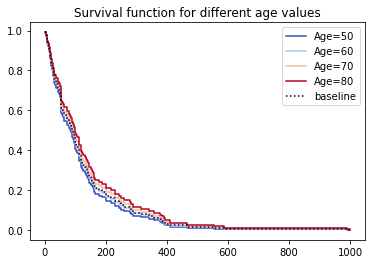

In [17]:
cph.plot_partial_effects_on_outcome(covariates = "Age", values = [50, 60, 70, 80], cmap = 'coolwarm')
plt.title("Survival function for different age values")
plt.show()

## Plot Coefficients

### Plot the ranking of variables in terms of their log(HR) using the **.plot( )** method.
**log(HR)** - natural logarithm of the hazard ratio (HR) in survival analysis. 

**The hazard ratio is a measure of the relative risk of experiencing an event (such as death, failure, or any predefined outcome) between two groups or levels of a covariate.**

**By taking the natural logarithm (log base e) of the hazard ratio, the resulting value is known as the "log(HR)" or "log hazard ratio." 

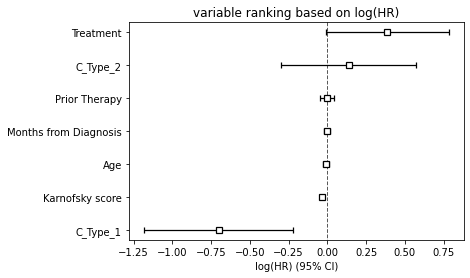

In [18]:
cph.plot()
plt.title("variable ranking based on log(HR)")
plt.show()

## The hazard ratios and confidence intervals calculated from a Cox proportional hazard model

In [19]:
hazard_ratios = cph.hazard_ratios_
confidence_intervals = cph.confidence_intervals_

print("Hazard Ratios:", hazard_ratios)
print("Confidence Intervals:", confidence_intervals)

Hazard Ratios: covariate
Treatment                1.471277
Karnofsky score          0.966590
Months from Diagnosis    0.998844
Age                      0.992782
Prior Therapy            0.999734
C_Type_1                 0.496556
C_Type_2                 1.146836
Name: exp(coef), dtype: float64
Confidence Intervals:                        95% lower-bound  95% upper-bound
covariate                                              
Treatment                    -0.009221         0.781482
Karnofsky score              -0.044770        -0.023191
Months from Diagnosis        -0.019028         0.016715
Age                          -0.025262         0.010774
Prior Therapy                -0.045172         0.044640
C_Type_1                     -1.181258        -0.218859
C_Type_2                     -0.300560         0.574574


### References : https://www.stat.rice.edu/~sneeley/STAT553/Datasets/survivaldata.txt , FMI - Biostatistics course - Lecture 10 - Survival analysis: basic definitions, Kaplan-Maier method, log-rank test and Cox model, https://www.youtube.com/watch?v=PH2o_KVF7Jw, https://en.wikipedia.org/wiki/Performance_status , https://www.uptodate.com/contents/image?imageKey=PC%2F58785